# Домашнее задание № 7 (демо)<br>Обучение без учителя: метод главных компонент и кластеризация

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации. 

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1qzcrfsNFy-e4TW59v2fqMj_OTom2SIOxtq4MWlI92p0).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("../Data/samsung_HAR/samsung_train.txt")
y_train = np.loadtxt("../Data/samsung_HAR/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("../Data/samsung_HAR/samsung_test.txt")
y_test = np.loadtxt("../Data/samsung_HAR/samsung_test_labels.txt").astype(int)

In [3]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*. 

In [4]:
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

Определим число уникальных значений меток целевого класса.

In [5]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [6]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [8]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
X_pca.shape

(10299, 65)

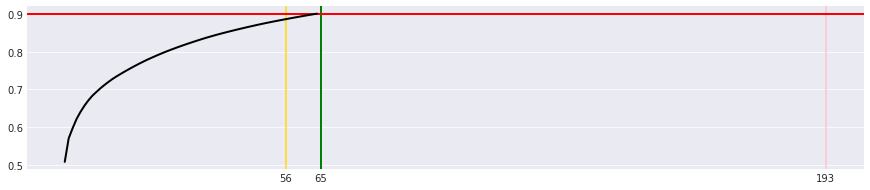

In [9]:
plt.figure(figsize=(15,3))

plt.axvline(56, c='gold')
plt.axvline(65, c='green', lw=2)
plt.axvline(193, c='pink')
plt.axhline(0.9, c='r', lw=2)
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xticks([56,65,193]);

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56 
- __65__
- 66
- 193

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов. 

In [10]:
int(round(pca.explained_variance_ratio_[0]*100))

51

**Варианты:**
- 45
- __51__
- 56
- 61

Визуализируйте данные в проекции на первые две главные компоненты.

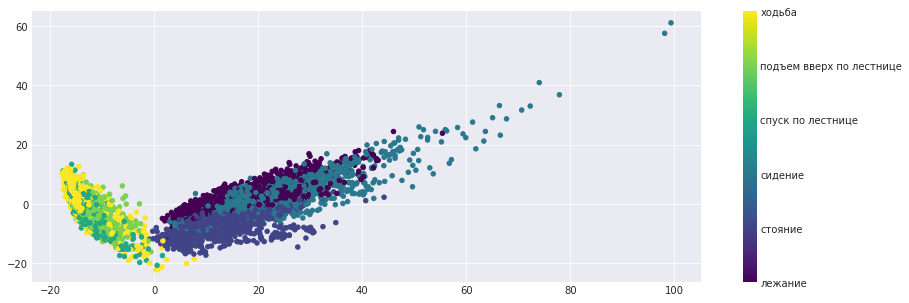

In [11]:
plt.figure(figsize=(15,5))
ax_labels = ['ходьба',
             'подъем вверх по лестнице',
             'спуск по лестнице',
             'сидение',
             'стояние',
             'лежание']
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=20, cmap='viridis')
plt.colorbar().ax.set_yticklabels(ax_labels[::-1]);

**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- __2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)__
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [12]:
kM = KMeans(n_clusters=n_classes, 
            n_init=100, n_jobs=-1,
            random_state=RANDOM_STATE)
kM.fit(X_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=100, n_jobs=-1, precompute_distances='auto',
       random_state=17, tol=0.0001, verbose=0)

In [13]:
cluster_labels = kM.labels_

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

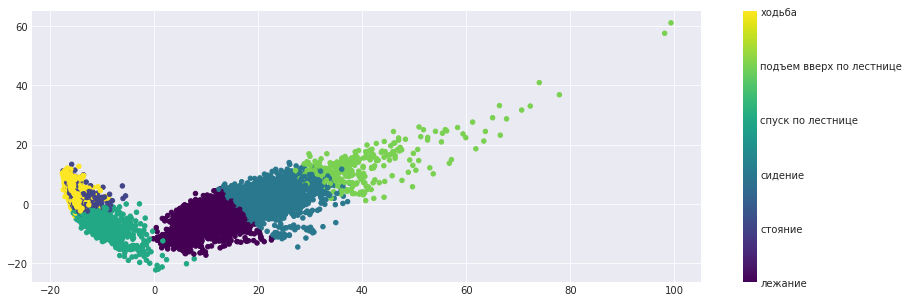

In [14]:
plt.figure(figsize=(15,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=cluster_labels, s=20,  cmap='viridis');
plt.colorbar().ax.set_yticklabels(ax_labels[::-1]);

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [15]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,903,0,741,0,78,0,1722
подъем вверх по лестнице,1241,0,296,2,5,0,1544
спуск по лестнице,320,0,890,0,196,0,1406
сидение,1,1235,0,450,0,91,1777
стояние,0,1344,0,562,0,0,1906
лежание,5,52,0,329,0,1558,1944
все,2470,2631,1927,1343,279,1649,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации. 

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,
 
то такая доля будет 900 / 1406 $\approx$ 0.64.
 

**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

In [16]:
action_dict = {}
for action in tab.index:
    values = list(tab.loc[action,:].values)
    last = values.pop()
    action_dict[action] = max(values)/last
print(list(action_dict.keys())[list(action_dict.values()).index(max(action_dict.values()))])

подъем вверх по лестнице


**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- __перечисленные варианты не подходят__

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


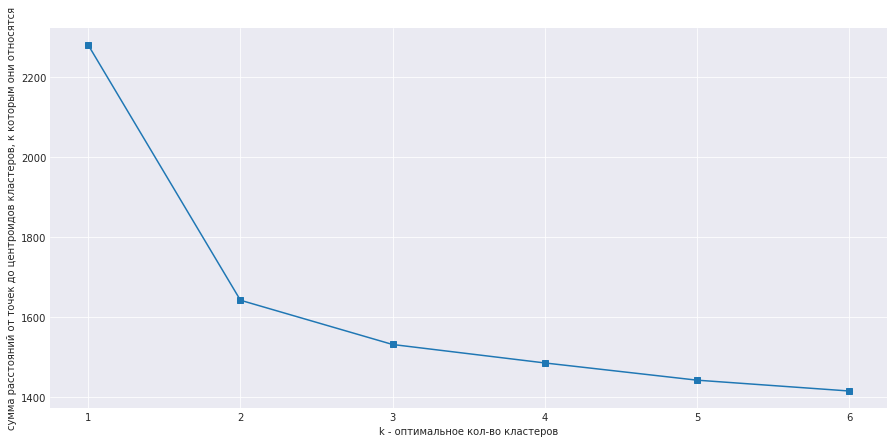

In [17]:
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)): # notebook.tqdm позволяет мониторить процесс выполнения цикла
    kM = KMeans(n_clusters=k, n_init=100, 
                random_state=RANDOM_STATE)
    kM.fit(X_pca)
    inertia.append(np.sqrt(kM.inertia_)) # список корня сумм квадратов расстояний от точек до центра кластера

plt.figure(figsize=(15,7))
plt.plot(range(1, n_classes + 1), inertia, marker='s');
plt.xlabel('k - оптимальное кол-во кластеров')
plt.ylabel('сумма расстояний от точек до центроидов кластеров, к которым они относятся');

In [18]:
d = {}
for k in range(2, 6):
    i = k - 1
    d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])
d

{2: 0.17344764581480915,
 3: 0.4168828316505664,
 4: 0.9332296467120299,
 5: 0.629698705328809}

**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- __2__
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [19]:
ag = AgglomerativeClustering(n_clusters=n_classes, linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [20]:
from sklearn.metrics.cluster import adjusted_rand_score

print('ARI для агломеративной кластеризации: {}\nARI для KMeans: {}'.format(
    adjusted_rand_score(y, ag.labels_), adjusted_rand_score(y, cluster_labels)))

ARI для агломеративной кластеризации: 0.49362763373004886
ARI для KMeans: 0.4198070012602345


**Вопрос 6:**<br>
Отметьте все верные утверждения.<br>

**Варианты:**
- __Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering__
- __Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры__
- __В случае случайного разбиения на кластеры ARI будет близок к нулю__
<hr>
- Чем выше ARI, тем лучше;
- Если перенумеровать кластеры по-другому, ARI не изменится.
<hr>

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf). 

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`. 

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [23]:
best_svc = GridSearchCV(svc, svc_params, cv=3, verbose=True)
best_svc.fit(X_train_scaled, y_train)
print(best_svc.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear 

{'C': 0.1}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


**Вопрос 7**<br>
Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- __0.1__
- 1
- 10

In [24]:
y_predicted = best_svc.predict(X_test_scaled)

In [25]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,412,1,1,0,420
сидение,0,4,0,427,60,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,412,443,589,526,2947


**Вопрос 8:**<br>
Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

In [26]:
from sklearn.metrics import precision_recall_curve, classification_report

report = classification_report(y_test, y_predicted, output_dict=True, target_names=ax_labels)
report_df = pd.DataFrame(report).T.loc[ax_labels,['precision', 'recall']]
report_df

,precision,recall
ходьба,0.972441,0.995968
подъем вверх по лестнице,0.978678,0.974522
спуск по лестнице,1.000000,0.980952
сидение,0.963883,0.869654
стояние,0.877759,0.971805
лежание,1.000000,0.979516


**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- __по точности – стояние, по полноте – сидение__
<hr>

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

In [27]:
pca = PCA(random_state=RANDOM_STATE, n_components=0.9)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [28]:
svc_pca = LinearSVC(random_state=RANDOM_STATE)
svc_pca_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [29]:
best_svc_pca = GridSearchCV(svc_pca, svc_pca_params, cv=3, verbose=True)
best_svc_pca.fit(X_train_pca, y_train)
print(best_svc_pca.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear 

{'C': 0.1}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


**Вопрос 9:**<br>
Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

In [30]:
round((best_svc_pca.best_score_*100 - best_svc.best_score_*100))

-4.0

**Варианты:**
- Качество одинаковое
- 2%
- __4%__ 
- 10%
- 20%

**Вопрос 10:**<br>
Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- __PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность__
- __PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком__

- Для визуализации многомерных данных лучше использовать методы manifold learning, в частности, tSNE. При этом до сих пор метрики, оценивающей качество визуализации, толком не придумали, но tSNE получил широкое распространение именно потому, что в некоторых случаях строит "хорошие" картинки, передающие структуру данных, как в примере с MNIST;
- Линейные комбинации признаков, которые строит PCA, могут плохо интерпретироваться человеком, например, 0.574 * salary + 0.234 * num_children